In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

In [37]:
import glob, time

## Functions

In [4]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [5]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [6]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [7]:
def event_size(df):
    return len(np.unique(df.event_id))

In [32]:
def xindex(x,mcrst, sx):
    return np.floor((x + mcrst.xmin + mcrst.dx)/sx)

def yindex(x,mcrst, sy):
    return np.floor((x + mcrst.ymin + mcrst.dy)/sy)

def zindex(x,mcrst, sz):
    return np.floor((x - mcrst.zmin)/sz)


In [271]:
def voxelize(gdfx,mcrst,i, sx,sy,sz,case='pixel', prnt=10):

    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    if i%prnt == 0:
        print(f"nx = {nx}, ny = {ny}, nz = {nz}")
        print(f"number of voxels = {nx*ny*nz}")
        print(f"index for xmin ={xindex(mcrst.xmin, mcrst, sx)} index for xmax ={xindex(mcrst.xmax, mcrst, sx)}")
        print(f"index for ymin ={yindex(mcrst.ymin, mcrst, sy)} index for ymax ={yindex(mcrst.ymax, mcrst, sy)}")
        print(f"index for zmin ={zindex(mcrst.zmin, mcrst, sz)} index for zmax ={zindex(mcrst.zmax, mcrst, sz)}")

    gdf["ix"]= xindex(gdf.x, mcrst, sx).astype(int)
    gdf["iy"]= yindex(gdf.y, mcrst, sy).astype(int)
    gdf["iz"]= zindex(gdf.z, mcrst, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    # prepare DF to compute baricenter: add columns with xiEi
    gdf = grdf.agg(
                ebox = ('E', 'sum'),
                tbox = ('initial_t', 'first'),     
                x1 = ('x', 'first'),     
                y1 = ('y', 'first'),        
                z1 = ('z', 'first'),        # z in the box is the y mean
                xbox = ('xE', 'sum'),     
                ybox = ('yE', 'sum'),        
                zbox = ('zE', 'sum'),        # z in the box is the y mean
                nbox = ('x', 'count'),  # this counts the number of occurences
                  ).reset_index()
    gdf['xbox'] = gdf['xbox'] / gdf['ebox']
    gdf['ybox'] = gdf['ybox'] / gdf['ebox']
    gdf['zbox'] = gdf['zbox'] / gdf['ebox']
    return gdf

In [10]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [150]:
def streams(gdx, i, nprnt):
    
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    if i%nprnt==0:
        print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
        print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
        print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    
    return df1g,df2g,dfng
   

## Globals

In [12]:
path_to_data=os.environ['MONOLITH_DATA'] 

In [13]:
npr=10
eth = 0.001 # in keV
lmax = 60 # in mm

## Code

In [14]:
dir = os.path.join(path_to_data,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX")

In [15]:
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [16]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )



In [17]:
def concat_df(file_paths, start=0, end=10):
    DF =[]
    for file in file_paths[start:end]:
        gammas = pd.read_hdf(file,"MC/particles")
        DF.append(gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1))
                      
    return pd.concat(DF, axis=0)

In [120]:
def compute_xyz(file_paths, start=0, end=10, eth=0.001, lmax=45, sx=6,sy=6,sz=6, bins=100,prnt=10):
    def xyz(h):
        zmin = np.ceil(h[0])
        zmax = np.floor(h[-1])
        dz = zmax - zmin
        return zmin, zmax, dz

    def FillXYZ(df, XYZ):               
        h, b = np.histogram(df.initial_z, bins)
        zmin, zmax, dz = xyz(b)          
        print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")
        h, b = np.histogram(df.initial_x, bins)
        xmin, xmax, dx = xyz(b)          
        print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")
        h, b = np.histogram(df.initial_y, bins)
        ymin, ymax, dy = xyz(b)          
        print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")
        XYZ.append(MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz))


    XYZ = []
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        if i%prnt ==0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")

        if i%prnt ==0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        if i%prnt ==0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        if i%prnt ==0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt ==0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        FillXYZ(gdf4, XYZ)

    return XYZ

In [258]:
def filter_df(file_paths, start=0, end=10, eth=0.001, lmax=60, prnt=10):

    DF =[]
    start_time = time.time()
    for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")
        gdf1 = gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf2 = select_gammas_interact_in_crystal(gdf1)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf3 = gdf2[gdf2['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf3.groupby('event_id')
        gdf4 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf5 = gdf4[(gdf4['kin_energy'] >eth) & (gdf4.length<lmax)]

        if i%prnt == 0:
            print(f"Drop some extra columns and rename fields: time = {time.time() - start_time}") 
        gdf6 = gdf5.drop(['final_x', 'final_y', 'final_z', 'length',
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)

        gdf6.rename(columns={'initial_x': 'x'}, inplace=True)
        gdf6.rename(columns={'initial_y': 'y'}, inplace=True)
        gdf6.rename(columns={'initial_z': 'z'}, inplace=True)
        gdf6.rename(columns={'kin_energy': 'E'}, inplace=True)

        if i%prnt == 0:
            print(f"Compute xiEi, yiEi, ziEi = {time.time() - start_time}") 

        gdf6['xE'] = gdf6['x'] * gdf6['E']
        gdf6['yE'] = gdf6['y'] * gdf6['E']
        gdf6['zE'] = gdf6['z'] * gdf6['E']
                
        DF.append(gdf6)

    print(f"now concat: time = {time.time() - start_time}") 
    df = pd.concat(DF, axis=0)

    print(f"after concat: time = {time.time() - start_time}") 
    return df




In [168]:
def filter_and_pixelize_df(file_paths, mcrst, start=0, end=10, eth=0.001, lmax=60, sx=6,sy=6,sz=6, prnt=10):

    Event1c =[] 	
    E = []
    X = []
    Y = []
    Z = []
    T = []

    Event2c =[] 	
    E1 = []
    X1 = []
    Y1 = []
    Z1 = []
    T1 = [] 

    E2 = []
    X2 = []
    Y2 = []
    Z2 = []
    T2 = [] 
    ET2 = []

    Eventnc =[]
    Eventt =[]
        
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")
        gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        if i%prnt == 0:
            print(f"voxelize: time = {time.time() - start_time}") 
        gdm = voxelize(gdf4,mcrst,i, sx,sy,sz,case='mono', prnt=prnt)

        ## Split data into three streams.
        #  Stream 1g: events with 1 cluster: true information: x,y,z,t,e
        #  Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
        #  Stream ng: events with more than 2 clusters: no true information needed
        df1g,df2g,dfng = streams(gdm, i, prnt)

        gdmx = gdm.drop(['ix', 'iy', 'iz', 
                   'nbox'], axis=1)
        gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
        gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
        gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]

        ## Two cluster case
        grdf = gdm2c.groupby('event_id')
        gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                e1 = ('ebox', 'first'),
                e2 = ('ebox', 'last'),
                x1 = ('xbox', 'first'),
                t1 = ('tbox', 'first'),
                x2 = ('xbox', 'last'),
                y1 = ('ybox', 'first'),
                y2 = ('ybox', 'last'),
                z1 = ('zbox', 'first'),
                z2 = ('zbox', 'last'),
                t2 = ('tbox', 'last')
                  ).reset_index()
        
        Event1c.extend(gdm1c.event_id.values) 
        E.extend(gdm1c.ebox.values) 	
        X.extend(gdm1c.xbox.values)
        Y.extend(gdm1c.ybox.values)
        Z.extend(gdm1c.zbox.values)
        T.extend(gdm1c.tbox.values)

        Event2c.extend(gdy2ca.event_id.values) 	
        E1.extend(gdy2ca.e1.values) 	
        X1.extend(gdy2ca.x1.values)
        Y1.extend(gdy2ca.y1.values)
        Z1.extend(gdy2ca.z1.values)
        T1.extend(gdy2ca.t1.values)
        E2.extend(gdy2ca.e2.values) 	
        X2.extend(gdy2ca.x2.values)
        Y2.extend(gdy2ca.y2.values)
        Z2.extend(gdy2ca.z2.values)
        T2.extend(gdy2ca.t2.values)
        ET2.extend(gdy2ca.etot.values) 

        Eventnc.extend(gdmnc.event_id.values) 
        Eventt.append(event_size(gdm))


    # Create composed dfs
    data = {
    'event_id': Event1c,
    'e': E,
    'x': X,
    'y': Y,
    'z': Z,
    't': T
    }
    df1c   = pd.DataFrame(data)

    data = {
    'event_id': Event2c,
    'e1': E1,
    'x1': X1,
    'y1': Y1,
    'z1': Z1,
    't1': T1,
    'e2': E2,
    'x2': X2,
    'y2': Y2,
    'z2': Z2,
    't2': T2,
    'etot': ET2
    }
    df2c   = pd.DataFrame(data)

    data = {
    'event_id': np.unique(np.array(Eventnc))}
    dfnc   = pd.DataFrame(data)
    
    return np.sum(Eventt), df1c, df2c, dfnc




In [82]:
def mean_XYZ(XYZ):
    XMIN = []
    XMAX = []
    YMIN = []
    YMAX = []
    ZMIN = []
    ZMAX = []
    for xyz in XYZ:
        XMIN.append(xyz.xmin)
        XMAX.append(xyz.xmax)
        YMIN.append(xyz.ymin)
        YMAX.append(xyz.ymax)
        ZMIN.append(xyz.zmin)
        ZMAX.append(xyz.zmax)
        zmin = np.ceil(h[0])
        zmax = np.floor(h[-1])
    xmin = np.ceil(np.mean(np.array(XMIN)))
    xmax = np.floor(np.mean(np.array(XMAX)))
    ymin = np.ceil(np.mean(np.array(YMIN)))
    ymax = np.floor(np.mean(np.array(YMAX)))
    zmin = np.ceil(np.mean(np.array(ZMIN)))
    zmax = np.floor(np.mean(np.array(ZMAX)))
    dx = xmax - xmin
    dy = ymax - ymin
    dz = zmax - zmin
    
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    return MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
        

In [136]:
XYZ = compute_xyz(file_paths, start=0, end=10, eth=0.001, lmax=45, sx=9,sy=9,sz=9, bins=100)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.06055855751037598
Remove primary gammas: time = 0.9247407913208008
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.7397027015686035
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 24.00, xmin = -24.00, dx = 48.00
ymax = 23.00, ymin = -23.00, dy = 46.00
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 24.00, xmin = -23.00, dx = 47.00
ymax = 23.00, ymin = -24.00, dy = 47.00
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 23.00, xmin = -24.00, dx = 47.00
ymax = 23.00, ymin = -23.00, dy = 46.00
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 23.00, xmin = -24.00, dx = 47.00
ymax = 23.00, ymin = -24.00, dy = 47.00
zmax = 50.00, zmin = 13.00, dz = 37.00
xmax = 24.00, xmin = -23.00, dx = 47.00
ymax = 24.00, ymin = -24.00, dy = 48.00
zmax = 51.00, zmin = 13.00, dz = 38.00
xmax = 24.00, xmin = -24.00, dx = 48.00
ymax = 23.00, ymin = -24.00, dy = 47.00
zmax = 51.00, zmin = 13.00, dz 

In [125]:
XYZ

[MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=24.0, dy=48.0, zmin=13.0, zmax=50.0, dz=37.0),
 MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-23.0, ymax=24.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-23.0, xmax=24.0, dx=47.0, ymin=-24.0, ymax=23.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=24.0, dy=47.0, zmin=13.0, zmax=51.0, dz=38.0),
 MCrst(xmin=-24.0, xmax=23.0, dx=47.0, ymin=-23.0, ymax=24.0, dy=47.0, zm

In [126]:
xyzc = mean_XYZ(XYZ)

In [127]:
xyzc

MCrst(xmin=-23.0, xmax=23.0, dx=46.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=50.0, dz=37.0)

In [259]:
gdf = filter_df(file_paths, start=0, end=5, eth=0.001, lmax=50, prnt=1)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.05827927589416504
Remove primary gammas: time = 0.9689884185791016
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.574235200881958
Drop some extra columns and rename fields: time = 2.575310230255127
Compute xiEi, yiEi, ziEi = 2.575937509536743
Reading data frame 1
Select events in which gammas interact in crystal: time = 2.629148006439209
Remove primary gammas: time = 3.377748966217041
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 4.999556064605713
Drop some extra columns and rename fields: time = 5.0010809898376465
Compute xiEi, yiEi, ziEi = 5.001757383346558
Reading data frame 2
Select events in which gammas interact in crystal: time = 5.055089950561523
Remove primary gammas: time = 5.932127237319946
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 7.529309272766113
Drop some extra c

In [260]:
gdf.columns

Index(['event_id', 'particle_id', 'particle_name', 'x', 'y', 'z', 'initial_t',
       'E', 'creator_proc', 'xE', 'yE', 'zE'],
      dtype='object')

In [261]:
gdf.head(20)

,event_id,particle_id,particle_name,x,y,z,initial_t,E,creator_proc,xE,yE,zE
0,680002,2,e-,17.471272,-21.407799,15.194095,0.070294,0.212338,compt,3.709820,-4.545696,3.226288
1,680002,25621,e-,16.308014,-8.935721,20.914680,0.116228,0.002909,compt,0.047434,-0.025991,0.060833
2,680002,26109,e-,15.823273,-6.602371,22.563520,0.125894,0.003268,phot,0.051706,-0.021575,0.073731
3,680002,26108,e-,15.823273,-6.602371,22.563520,0.125894,0.003892,phot,0.061591,-0.025699,0.087827
4,680002,26107,e-,15.823273,-6.602371,22.563520,0.125894,0.025294,phot,0.400234,-0.167000,0.570722
5,680002,26106,e-,15.823273,-6.602371,22.563520,0.125894,0.258608,phot,4.092019,-1.707424,5.835098
6,680005,3,e-,6.790020,7.181014,32.762108,0.128651,0.005044,compt,0.034246,0.036218,0.165239
7,680005,2,e-,6.790020,7.181014,32.762108,0.128651,0.222331,compt,1.509632,1.596563,7.284034
8,680005,27589,e-,15.265637,4.257829,35.750702,0.160174,0.080053,compt,1.222063,0.340853,2.861958
9,680005,37070,e-,18.203693,2.432415,30.927778,0.179971,0.003284,phot,0.059776,0.007987,0.101558


In [262]:
len(gdf)

103126

In [263]:
def compute_deltas(df):
    grdf = df.groupby('event_id')
    i=0
    DX1 = []
    DY1 = []
    DZ1 = []

    i=0
    for name, gr in grdf:
        DX1.extend(np.diff(gr.x))
        DY1.extend(np.diff(gr.y))
        DZ1.extend(np.diff(gr.z))

    return np.array(DX1),np.array(DY1),np.array(DZ1)

In [264]:
DX,DY,DZ = compute_deltas(gdf)

In [265]:
def plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=1.0):
    fig, ax = plt.subplots(2, 3, figsize=figsize)
        
    h00 = ax[0,0].hist(DX,bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(DY,bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[0,2].hist(DZ,bins)
    ax[0,2].set_xlabel("Dz (mm)")
    ax[0,2].set_ylabel("entries")
    
    h10 = ax[1,0].hist(DX[np.abs(DX)>cut],bins)
    ax[1,0].set_xlabel("Dx1 (mm)")
    ax[1,0].set_ylabel("entries")

    h11 = ax[1,1].hist(DY[np.abs(DY)>cut],bins)
    ax[1,1].set_xlabel("Dy1 (mm)")
    ax[1,1].set_ylabel("entries")
   
    h12 = ax[1,2].hist(DZ[np.abs(DZ)>cut],bins)
    ax[1,2].set_xlabel("Dz1 (mm)")
    ax[1,2].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()
  

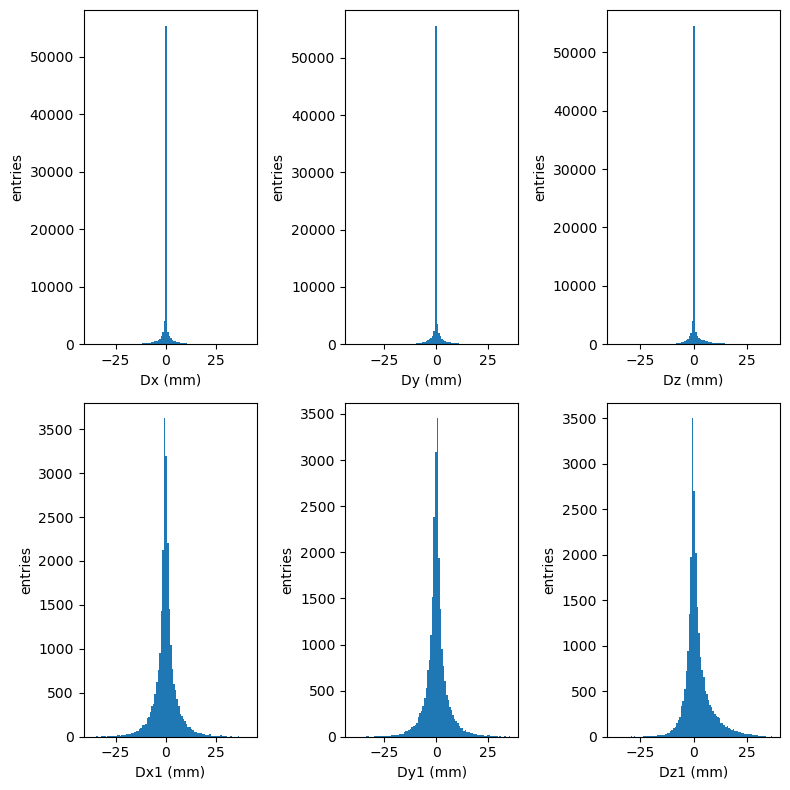

In [266]:
plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=0.1)

In [298]:
gdfb = voxelize(gdf,xyzc,1, sx=9,sy=9,sz=9,case='pixel', prnt=1)

nx = 5, ny = 5, nz = 4
number of voxels = 100
index for xmin =0.0 index for xmax =5.0
index for ymin =0.0 index for ymax =5.0
index for zmin =0.0 index for zmax =4.0


In [299]:
gdfb

,event_id,ix,iy,ebox,tbox,x1,y1,z1,xbox,ybox,zbox,nbox
0,80000,1,3,0.267142,0.164965,-6.468779,6.699799,30.230259,-6.468779,6.699799,30.230259,1
1,80000,2,3,0.020861,0.157675,-4.326902,6.266281,30.262753,-4.326902,6.266281,30.262754,1
2,80000,3,2,0.221678,0.111498,5.410841,-2.503098,27.528318,5.466898,-2.214287,27.972820,2
3,80001,5,1,0.480867,0.148258,23.959150,-6.985072,38.808884,23.959150,-6.985072,38.808884,2
4,80002,1,2,0.508781,0.079224,-5.889712,-4.328921,17.513109,-5.889712,-4.328921,17.513107,2
...,...,...,...,...,...,...,...,...,...,...,...,...
37927,977809,1,0,0.510695,0.092527,-8.383177,-18.148294,21.760221,-9.999410,-18.449104,21.178093,3
37928,977810,0,1,0.509517,0.102208,-22.131554,-10.525648,24.818983,-22.131552,-10.525648,24.818983,3
37929,977812,1,2,0.229196,0.222152,-13.785409,-4.431967,27.472837,-13.785410,-4.431967,27.472839,3
37930,977812,3,3,0.280461,0.144201,5.510693,4.452209,37.211765,5.510693,4.452209,37.211765,1


In [305]:
def plotboxd(gdf,bins=100, figsize=(8,8)):
   
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    dx =gdf.x1 - gdf.xbox
    dy =gdf.y1 - gdf.ybox
    dz =gdf.z1 - gdf.zbox
    
    h00 = ax[0,0].hist(dx[np.abs(dx)>0.05],bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(dy[np.abs(dy)>0.05],bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[1,0].hist(dy[np.abs(dy)>0.05],bins)
    ax[1,0].set_xlabel("Dz (mm)")
    ax[1,0].set_ylabel("entries")
    
    h10 = ax[1,1].hist(dx,bins)
    ax[1,1].set_xlabel("Dx1 (mm)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

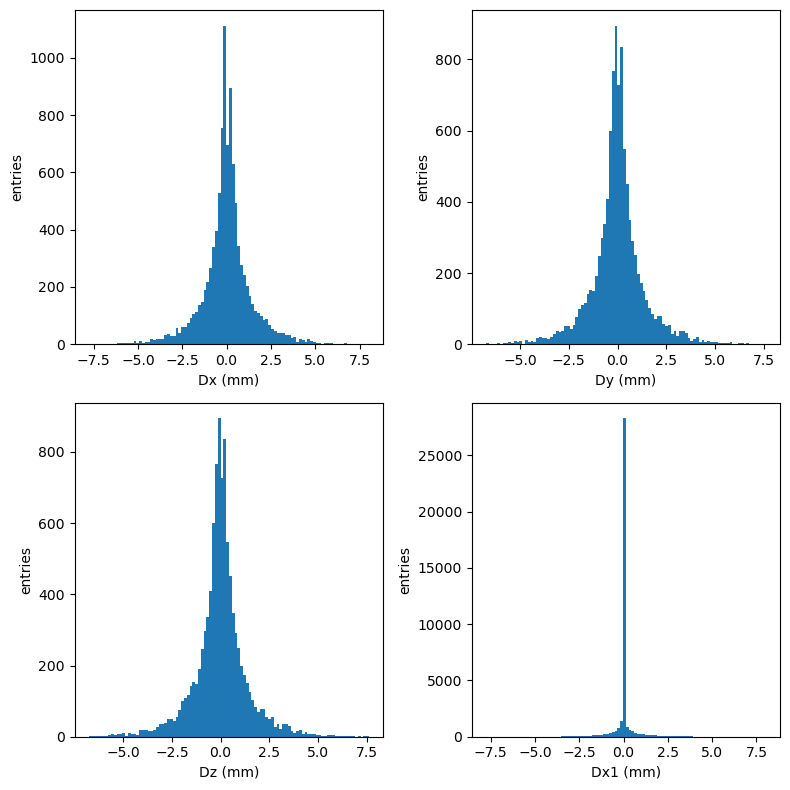

In [306]:
plotboxd(gdfb,bins=100, figsize=(8,8))

In [302]:
 df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.60
 fraction of events 2g = 0.33
 fraction of events >3g = 0.07


In [295]:
df1c

,event_id,etot,ngama
1,80001,0.480867,1
2,80002,0.508781,1
3,80003,0.509717,1
7,80009,0.508684,1
9,80012,0.510061,1
...,...,...,...
25628,977796,0.509780,1
25629,977797,0.510224,1
25630,977798,0.510097,1
25634,977803,0.509106,1


In [296]:
gdf1c = gdfb[gdfb['event_id'].isin(df1c.event_id.values)]
gdf1c.head(npr)

,event_id,ix,iy,ebox,tbox,x1,y1,z1,xbox,ybox,zbox,nbox
3,80001,15,5,0.480867,0.148258,23.959150,-6.985072,38.808884,23.959150,-6.985072,38.808884,2
4,80002,5,6,0.508781,0.079224,-5.889712,-4.328921,17.513109,-5.889712,-4.328921,17.513107,2
5,80003,3,0,0.509717,0.070026,-12.340251,-21.046457,14.876266,-12.340251,-21.046457,14.876266,3
13,80009,15,2,0.508684,0.120917,22.433792,-16.038836,30.602848,22.385742,-16.047377,30.615892,5
16,80012,6,10,0.510061,0.068149,-3.479884,7.682881,14.283337,-3.479885,7.682882,14.283338,2
28,80018,10,2,0.510212,0.091211,8.760658,-16.124321,21.271708,8.760658,-16.124323,21.271709,3
29,80019,6,14,0.509274,0.099107,-2.363723,19.402481,23.463057,-2.363723,19.402483,23.463058,3
30,80021,11,7,0.509634,0.105383,11.403864,-0.754258,25.546322,11.403864,-0.754258,25.546320,3
37,80024,11,12,0.509166,0.109443,10.783176,14.268790,27.031481,10.783176,14.268789,27.031479,2
38,80025,4,2,0.509771,0.070300,-10.196456,-16.107761,15.257592,-10.196456,-16.107761,15.257592,3


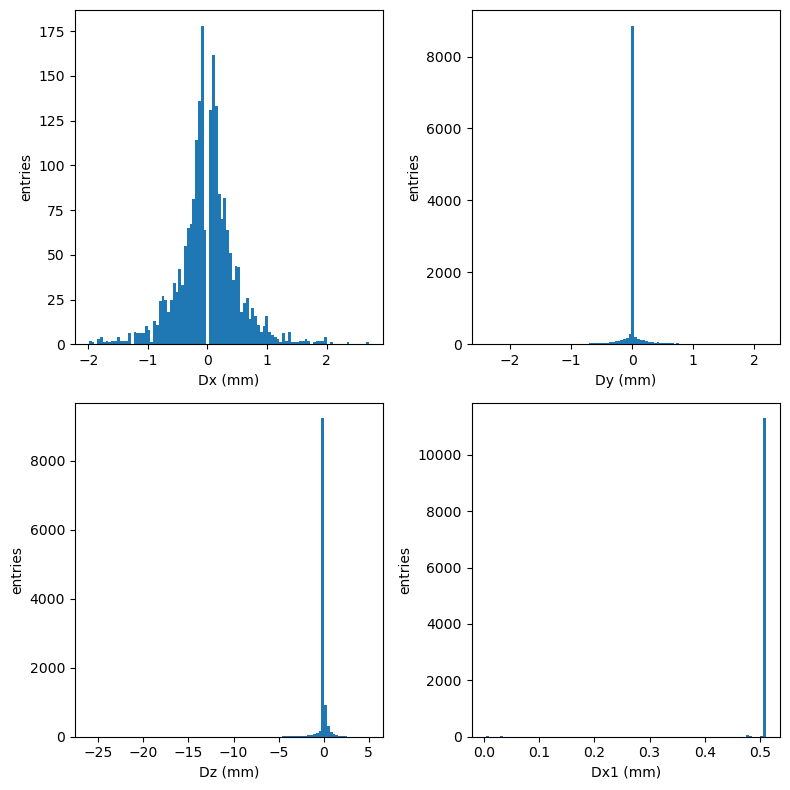

In [297]:
plotboxd(gdf1c,bins=100, figsize=(8,8))

In [288]:
gdf2c = gdfb[gdfb['event_id'].isin(df2c.event_id.values)]
gdf2c.head(npr)

,event_id,ix,iy,ebox,tbox,x1,y1,z1,xbox,ybox,zbox,nbox
7,80007,0,6,0.264115,0.195250,-19.787241,15.334354,39.266430,-19.787239,15.334354,39.266430,4
8,80007,2,7,0.243590,0.151646,-7.855597,20.673695,39.170135,-7.855597,20.673697,39.170135,2
9,80008,7,6,0.291040,0.166091,20.947853,17.495640,40.288227,20.648516,16.659609,40.312832,6
10,80008,7,7,0.215217,0.149551,19.639753,22.075415,38.909229,19.639753,22.075415,38.909233,1
12,80010,1,3,0.255935,0.118605,-15.376327,0.869803,22.473385,-15.258370,0.865187,22.418060,4
13,80010,2,4,0.253692,0.095937,-10.704307,5.804296,22.426170,-10.704307,5.804296,22.426170,1
18,80014,5,6,0.171318,0.087423,12.768630,17.875677,13.940916,12.768631,17.875677,13.940917,3
19,80014,6,6,0.337344,0.077376,13.089597,17.981054,16.901628,13.089598,17.981054,16.901628,1
20,80016,0,0,0.219791,0.184308,-19.808893,-19.919548,40.759872,-19.808891,-19.919548,40.759872,3
21,80016,1,0,0.289269,0.163391,-14.208335,-17.632078,42.410988,-14.208336,-17.632078,42.410988,1


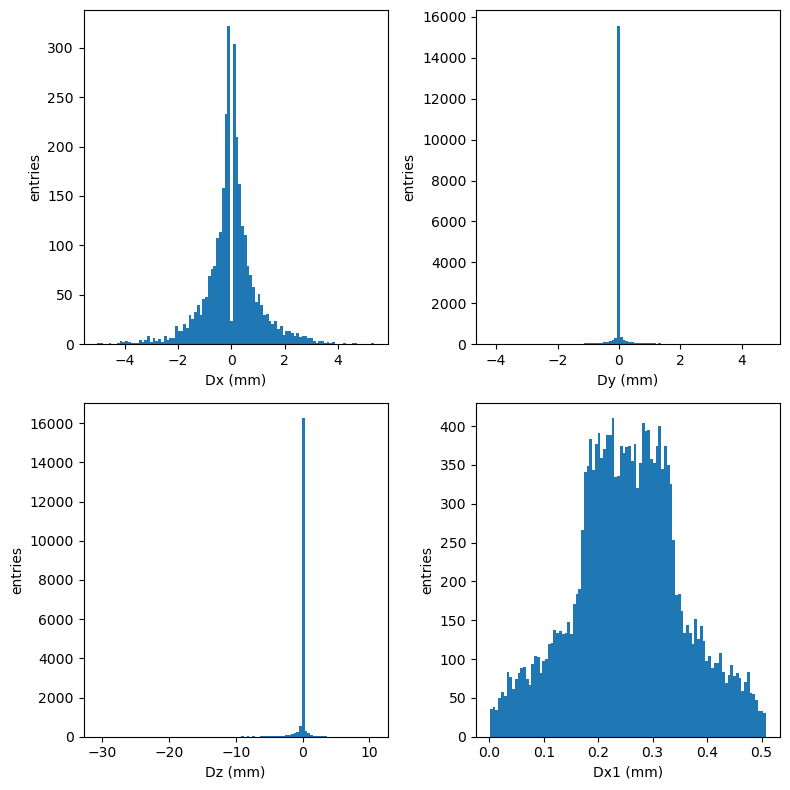

In [289]:
plotboxd(gdf2c,bins=100, figsize=(8,8))

In [157]:
ntot, df1c, df2c, dfnc = filter_df(file_paths, xyzc, start=0, end=5, eth=0.001, lmax=50, sx=12,sy=12,sz=12, prnt=5)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.06806731224060059
Remove primary gammas: time = 0.878364086151123
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.67376708984375
voxelize: time = 2.6748006343841553
nx = 3, ny = 3, nz = 3
number of voxels = 27
index for xmin =0.0 index for xmax =3.0
index for ymin =0.0 index for ymax =3.0
index for zmin =0.0 index for zmax =3.0
 fraction of events 1g = 0.58
 fraction of events 2g = 0.34
 fraction of events >3g = 0.08


In [158]:
print(f" fraction of events 1g = {(event_size(df1c)/ntot):.2f}")
print(f" fraction of events 1g = {(event_size(df2c)/ntot):.2f}")
print(f" fraction of events 1g = {(event_size(dfnc)/ntot):.2f}")

 fraction of events 1g = 0.57
 fraction of events 1g = 0.34
 fraction of events 1g = 0.09


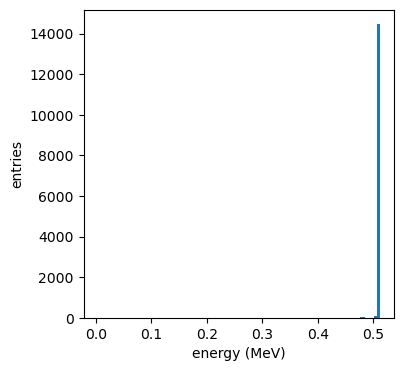

In [159]:
b, e = histoplot(df1c.e, 'energy (MeV)', "entries", bins=100, figsize=(4,4))

In [160]:
def plotd1c(bins=100, figsize=(8,8)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    _ = ax[0,0].hist(df1c.x,bins)
    ax[0,0].set_xlabel("x (mm)")
    ax[0,0].set_ylabel("entries")
    #ax[0,0].set_title("x")
    _ = ax[0,1].hist(df1c.y,bins)
    ax[0,1].set_xlabel("y (mm)")
    ax[0,1].set_ylabel("entries")
    _ = ax[1,0].hist(df1c.z,bins)
    ax[1,0].set_xlabel("z (mm)")
    ax[1,0].set_ylabel("entries")
    _ = ax[1,1].hist(df1c.t,bins)
    ax[1,1].set_xlabel("t (ns)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

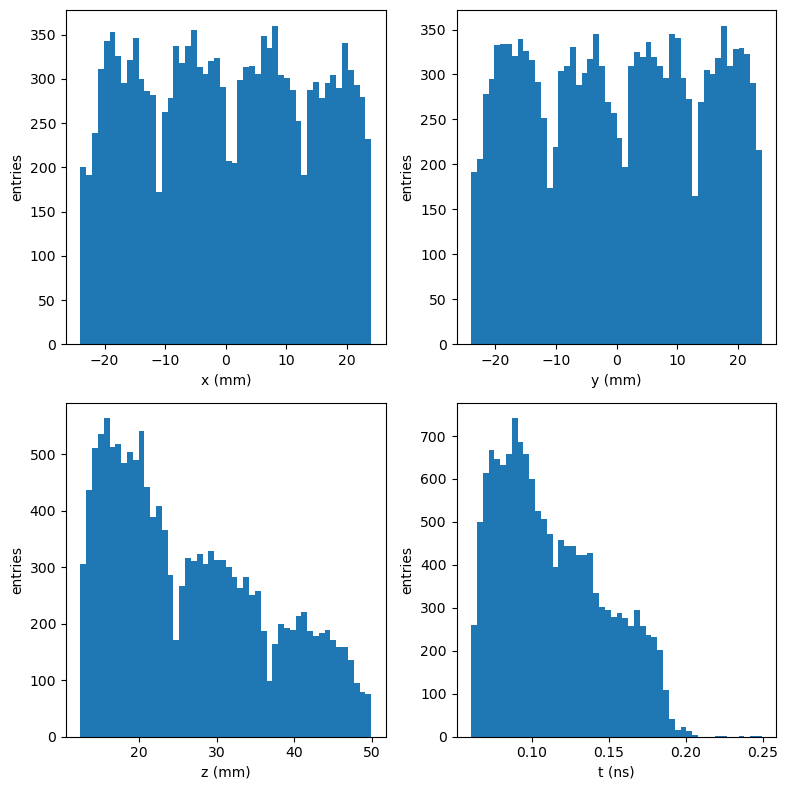

In [161]:
plotd1c(bins=50, figsize=(8,8))

Text(0, 0.5, 'e2 (mm)')

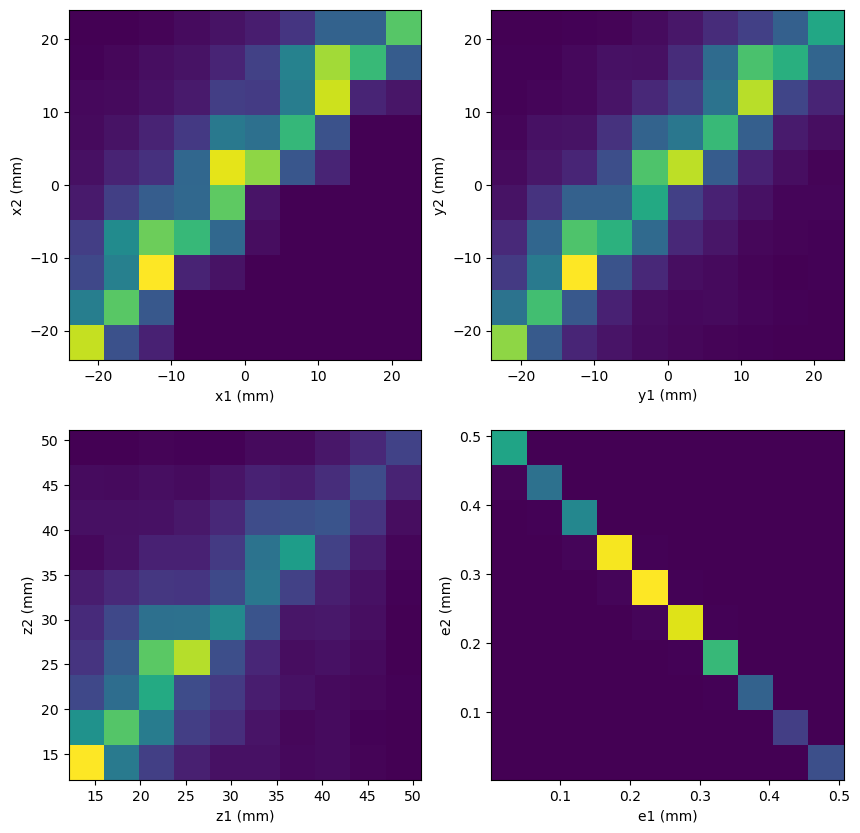

In [162]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(df2c.x1, df2c.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(df2c.y1, df2c.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(df2c.z1, df2c.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(df2c.e1, df2c.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')

In [140]:
def distance():
    return np.sqrt((df2c.x1 - df2c.x2)**2 + (df2c.y1 - df2c.y2)**2 + (df2c.z1 - df2c.z2)**2)

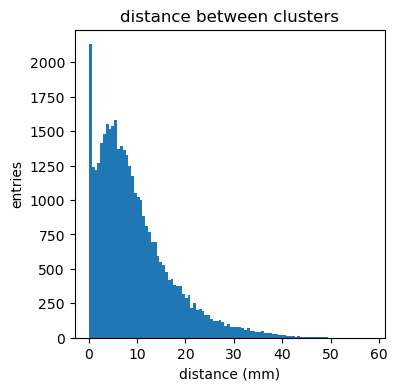

In [141]:
h = histoplot(distance(), "distance (mm)", "entries", bins=100, figsize=(4,4), title="distance between clusters")